In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
TAG = pd.read_csv("testData.csv",header=0)
TAG,outcome = TAG.iloc[:,0:4],TAG.iloc[:,4]

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-3


n_actions = 2 # 0 -> no anomaly, 1 -> anomaly


#state is the observation of the environment
state = TAG.iloc[0] #reset the environment and get the initial state - will need to import the data
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.choice([0, 1])]], device=device, dtype=torch.long) # 0 -> no anomaly, 1 -> anomaly


episode_rewards = []


def plot_rewards(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [9]:
def rewarding(action,iteration):
    if action == outcome[iteration]: #if correct action
      if action == 0: #if no anomaly
         return 1
      else: #if anomaly
         return 100
    else: #if wrong action
      if action == 0: #says no anomaly but there is
         return -3
      else: #says there is anomaly but there isn't
         return -1

In [9]:
if torch.cuda.is_available():
    num_episodes = 600 #600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state = TAG.iloc[0] #reset the environment and get the initial state - will need to import the data
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    totalReward = 0
    for t in count():
        #i_episode is the episode number
        #t is the time step within the episode
        action = select_action(state)
        reward = rewarding(action.item(),t)      
        totalReward += reward
        reward = torch.tensor([reward], device=device)
        if t == len(TAG)-1:
            done = True
        else:
            observation = TAG.iloc[t+1]
            done = False


        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(totalReward)
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Trial 2

In [35]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-3


n_actions = 2 # 0 -> no anomaly, 1 -> anomaly


#state is the observation of the environment
state = TAG.iloc[0] #reset the environment and get the initial state - will need to import the data
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_rewards = []


In [36]:
TAG2 = pd.read_csv("testData.csv",header=0)
TAG2,outcome2 = TAG2.iloc[:,0:4],TAG2.iloc[:,4] # split into observations and outcomes

# Make it episodic - split into episodes of n time steps # With N = 1000 each episode is 1000 time steps - 1 total episode
# Each episode is a sequence of observations with a single outcomes - 1 if at least one of the observations is 1, 0 otherwise

# TAG2 needs to be a 2D list where 1st dimension is the episode and 2nd dimension are the time steps within the episode

N = 100 # 10 steps per episode
step = int(len(TAG2)/N)
temp = []
for i in range(0,len(TAG2),step): 
    # This is sketchy as it assumes that len(TAG2) is divisible by N - this code needs to be adapted to the generic case at some point
    temp.append(TAG2.iloc[i:i+step].values)
TAG2 = temp

# Now need to handle the outcomes
temp = []
for i in range(0,len(outcome2),step):
    # This is sketchy as it assumes that len(TAG2) is divisible by N - this code needs to be adapted to the generic case at some point
    holdingOutcome = outcome2.iloc[i:i+step].values
    for j in range(0,len(holdingOutcome)):
        if holdingOutcome[0] == 1:
            temp.append(1)
            break
        else:
            pass
        temp.append(0)
outcome2 = temp

# probably want to put a buffer window of X time steps around the anomaly to make it easier to detect
#buffer = 5
#temp = []
#pointer = 0 
#while pointer < len(outcome2):
#    if outcome2[pointer] == 1:
#        for i in range(pointer-buffer,pointer+buffer):
#            outcome2[i] = 1
#        pointer += buffer
#    else:
#        pointer += 1

In [37]:
def rewarding(action,iteration):
    if action == outcome2[iteration]: #if correct action
      if action == 0: #if no anomaly
         return 1
      else: #if anomaly
         return 5
    else: #if wrong action
      if action == 0: #says no anomaly but there is
         return -5
      else: #says there is anomaly but there isn't
         return -1

In [38]:

names = TAG.iloc[0].index.values

Complete


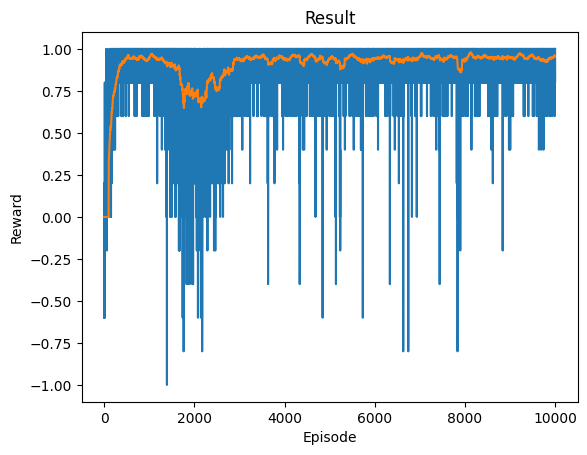

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
if torch.cuda.is_available():
    num_episodes = N 
else:
    num_episodes = 50 #Dont use CPU :)

epoch = 100 #Do every episode 100 times
for eachEpoch in range(epoch):
    #print("Epoch: ",eachEpoch)
    for i_episode in range(num_episodes):
        #print("Episode: ",i_episode,)
        # Initialize the environment and get its state
        #state = TAG2.iloc[0] #reset the environment and get the initial state - will need to import the data
        # Instead get the start of the episode
     
        episode = TAG2[i_episode]
        state = torch.tensor(pd.Series(episode[0],index=names), dtype=torch.float32, device=device).unsqueeze(0)
        totalReward = 0
        for t in count():
            #i_episode is the episode number
            #t is the time step within the episode
            action = select_action(state)
            reward = rewarding(action.item(),i_episode) # reward of the episode
            totalReward += reward
            reward = torch.tensor([reward], device=device)
            if t == len(episode)-1:
                done = True
            else:
                observation = pd.Series(episode[t+1],index=names)
                done = False


            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                maxReward = len(episode) * rewarding(outcome2[i_episode],i_episode)
                rewardPercent = totalReward/maxReward
                episode_rewards.append(rewardPercent)
                plot_rewards()
                break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()